In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import os, zipfile, shutil
import glob

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, Activation

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

In [2]:
IMG_CLASSES = ['sandwich','sushi']    # class 0: sandwich and class 1: sushi
dataset_home = "sushi_or_sandwich"          # directory name same as original sushi_or_sandwich_photos.zip
train_dir = "{}/train".format(dataset_home)
test_dir = "{}/test".format(dataset_home)
sushidi_dir= "{}/sushidi".format(dataset_home)

In [3]:
nb_epoch=20
img_width, img_height = 150, 150
input_shape = (150, 150, 3)
batch_size = 32

In [4]:
#Download sushi and sandwich photos
if not os.path.isfile('sushi_or_sandwich_photos.zip'):
  !wget http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip  

--2021-07-19 06:38:23--  http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip
Resolving research.us-east-1.s3.amazonaws.com (research.us-east-1.s3.amazonaws.com)... 52.217.165.153
Connecting to research.us-east-1.s3.amazonaws.com (research.us-east-1.s3.amazonaws.com)|52.217.165.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94457826 (90M) [application/zip]
Saving to: ‘sushi_or_sandwich_photos.zip’

sushi_or_sandwich_p 100%[===================>]  90.08M  70.5MB/s    in 1.3s    

2021-07-19 06:38:25 (70.5 MB/s) - ‘sushi_or_sandwich_photos.zip’ saved [94457826/94457826]



In [5]:
# Extract the data if not already extracted
if not os.path.isdir(dataset_home):
    dataset_zipfile = zipfile.ZipFile('sushi_or_sandwich_photos.zip', 'r')
    dataset_zipfile.extractall('./')
    dataset_zipfile.close() 

In [6]:
# Delete existing directories, create the new train and test directory for sandwich annd sushi
for img_class in IMG_CLASSES:
    for dir in [train_dir, test_dir]:
        this = '{}/{}'.format(dir,img_class)
        if os.path.isdir(this):
            shutil.rmtree(this)
        os.makedirs(this)

In [7]:
# split the data with 75 % training data and 25 % test data. I am choosing permutation sequence
val_ratio = 0.25
for img_class in IMG_CLASSES:
    files = glob.glob('{}/{}/*.jpg'.format(dataset_home,img_class))

    sequences = np.random.permutation(len(files))
    train_test_split_data = int(len(files)*val_ratio)
    for i,j in enumerate(sequences):
        source = files[j]
        destination = '{}/{}/{}'.format(test_dir if i < train_test_split_data else train_dir,img_class,files[j].split('/')[-1])
        shutil.copyfile(source, destination)

In [8]:
# Create train and test data generators with data augmentation using imagedatagenerator 
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range=0.2,
    zoom_range = 0.2,
    rotation_range=30)

train_datagen  = datagen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "binary",
    shuffle = True,
)

test_datagen  = datagen.flow_from_directory(
    test_dir,
    color_mode = 'rgb',    
    target_size = (img_height, img_width),
    batch_size = batch_size,     
    class_mode = "binary",
    shuffle = True,
)

Found 604 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


{'sandwich': 0, 'sushi': 1}


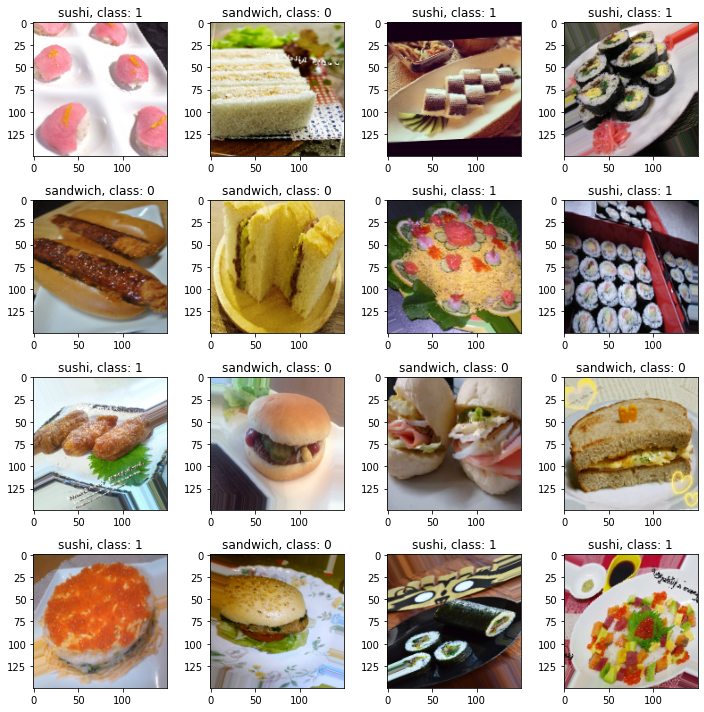

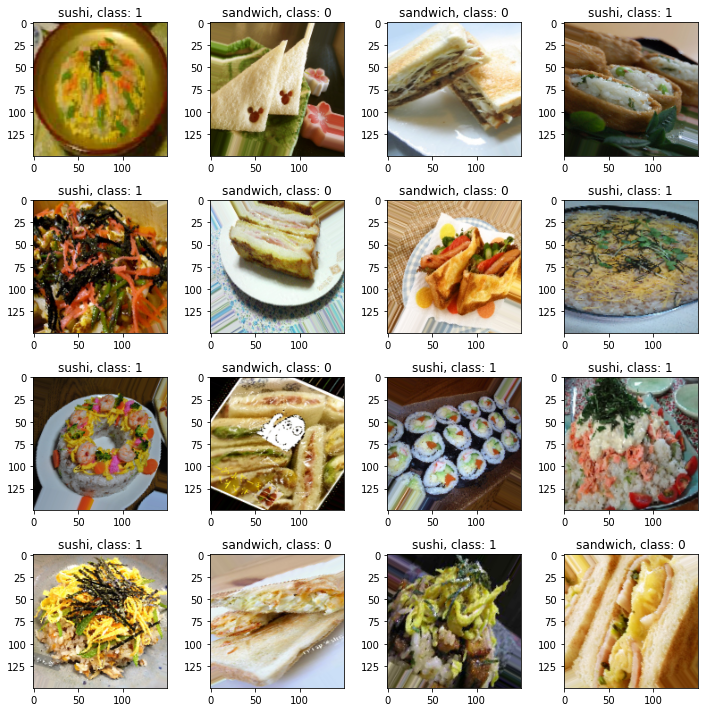

In [9]:
# Observe the traning Images 
print(train_datagen.class_indices)

images,img_labels=train_datagen[0]

for ix,(im,l) in enumerate(zip(images,img_labels)):
    if ix%16 == 0:
        plt.figure(figsize=(10,10))
    plt.subplot(4,4,ix%16+1)
    plt.imshow(im)
    if l == 0:
      #plt.title('sandwich')
      plt.title('sandwich, class: {:0.0f}'.format(l))
    elif l ==1: 
       plt.title('sushi, class: {:0.0f}'.format(l))
    #plt.title('Truth: {:0.0f}'.format(l))
    if (ix+1)%16 == 0:
        plt.tight_layout()

In [10]:
train_sandwich_dir = train_dir + "/sandwich"
train_sandwich_names = os.listdir(train_sandwich_dir)
train_sushi_dir = train_dir + "/sushi"
train_sushi_names = os.listdir(train_sushi_dir)

Visualize the Training as well as Test data

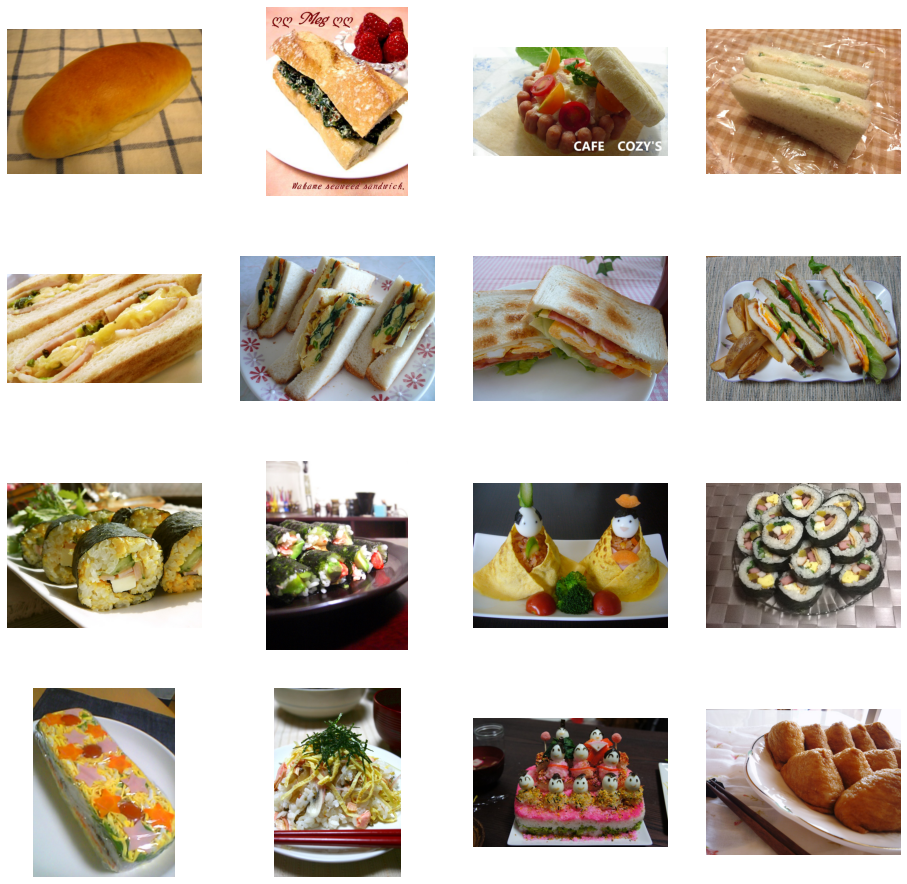

In [11]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_sandwich_pix = [os.path.join(train_sandwich_dir, fname) 
                for fname in train_sandwich_names[pic_index-8:pic_index]]
next_sushi_pix = [os.path.join(train_sushi_dir, fname) 
                for fname in train_sushi_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sandwich_pix+next_sushi_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)


In [12]:
# Generating training and test data which will be fed to model to predict
train_generator = datagen.flow_from_directory(
        train_dir,
        color_mode = 'rgb',
        target_size = (img_height, img_width),
        batch_size = batch_size, 
        class_mode = None,
        shuffle = False,
    )
test_generator = datagen.flow_from_directory(
        test_dir,
        color_mode = 'rgb',    
        target_size = (img_height, img_width),
        batch_size = batch_size,     
        class_mode = None,
        shuffle = False,
    ) 

Found 604 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


**Using  VGG16**

In [13]:
model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)


58892288/58889256 [==============================] - 0s 0us/step


In [14]:
train_modelVgg16 = model_vgg16.predict(train_generator,verbose=1)
test_modelVgg16 = model_vgg16.predict(test_generator,verbose=1) 
train_labels  = train_datagen.classes
test_labels = test_datagen.classes


7/7 [==============================] - 4s 534ms/step


In [15]:
model_Vgg16 = Sequential()

# Specify the input size for first layer
model_Vgg16.add(Flatten(input_shape=train_modelVgg16.shape[1:]))
model_Vgg16.add(Dense(150))           

# Create the model for Relu as hidden layer
model_Vgg16.add(Activation('relu'))
model_Vgg16.add(Dropout(0.5))
model_Vgg16.add(Dense(1))

# output layer
model_Vgg16.add(Activation('sigmoid'))

model_Vgg16.summary()

# Compile model
model_Vgg16.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# I tried with multiple network combination to increase the accuracy 
# 2nd Network
'''modelVgg16 = Sequential()

modelVgg16.add(Flatten(input_shape=train_modelVgg16.shape[1:]))

modelVgg16.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))
modelVgg16.add(layers.Dropout(0.25))

modelVgg16.add(layers.Dense(64, activation='relu', kernel_regularizer= l2(1e-04)))
modelVgg16.add(layers.Dropout(0.25))
modelVgg16.add(layers.Dense(32, activation='relu'))
# output layer
modelVgg16.add(layers.Dense(1, activation='sigmoid'))

modelVgg16.summary()

modelVgg16.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])'''

# 3rd Network
# Create the model for Relu as hidden layer
'''modelVgg16 = Sequential()

# Specify the input size for first layer
modelVgg16.add(Flatten(input_shape=train_modelVgg16.shape[1:]))
modelVgg16.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))
modelVgg16.add(layers.Dropout(0.25))

# output layer
modelVgg16.add(layers.Dense(1, activation='sigmoid'))
modelVgg16.summary()
# Compile model
opt1= Adam(learning_rate=1e-03)
modelVgg16.compile(loss='binary_crossentropy', optimizer=opt1, metrics=['accuracy'])'''


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               1228950   
_________________________________________________________________
activation (Activation)      (None, 150)               0         
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 1,229,101
Trainable params: 1,229,101
Non-trainable params: 0
______________________________________________

"modelVgg16 = Sequential()\n\n# Specify the input size for first layer\nmodelVgg16.add(Flatten(input_shape=train_modelVgg16.shape[1:]))\nmodelVgg16.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))\nmodelVgg16.add(layers.Dropout(0.25))\n\n# output layer\nmodelVgg16.add(layers.Dense(1, activation='sigmoid'))\nmodelVgg16.summary()\n# Compile model\nopt1= Adam(learning_rate=1e-03)\nmodelVgg16.compile(loss='binary_crossentropy', optimizer=opt1, metrics=['accuracy'])"

In [16]:
# Train the VGG16 model
history_Vgg16 = model_Vgg16.fit(
        train_modelVgg16,
        train_labels,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(test_modelVgg16, test_labels))

Epoch 1/20
19/19 [==============================] - 13s 30ms/step - loss: 2.0895 - accuracy: 0.5467 - val_loss: 0.5056 - val_accuracy: 0.7600
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 0.5438 - accuracy: 0.7296 - val_loss: 0.7203 - val_accuracy: 0.6800
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 0.4965 - accuracy: 0.7951 - val_loss: 0.8593 - val_accuracy: 0.5850
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 0.4598 - accuracy: 0.7885 - val_loss: 0.6303 - val_accuracy: 0.6900
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3048 - accuracy: 0.8581 - val_loss: 1.1803 - val_accuracy: 0.5750
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3442 - accuracy: 0.8632 - val_loss: 0.4916 - val_accuracy: 0.8050
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3369 - accuracy: 0.8401 - val_loss: 0.5912 - val_accuracy: 0.7450
Epoch 8/20
19/19 [

In [17]:
print("\n==========================VGG16 Model Evalutation=========================\n")

testLossVgg16, testAccuracyvgg16 = model_Vgg16.evaluate( test_modelVgg16, test_labels)
print('\n')
print('Loss \t', testLossVgg16)
print('Accuracy ', testAccuracyvgg16 * 100, '%')
print('\n')
predictionsVgg16 = model_Vgg16.predict(test_modelVgg16)
y_pred = (predictionsVgg16 > 0.5)
y_pred = np.argmax(predictionsVgg16, axis=1)

print('Classification Report\n')
print(classification_report(test_labels,y_pred,zero_division=1))

print('\n')
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))


==========================VGG16 Model Evalutation=========================

7/7 [==============================] - 0s 3ms/step - loss: 0.7255 - accuracy: 0.8100


Loss 	 0.7255344986915588
Accuracy  81.00000023841858 %


Classification Report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       1.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.75      0.50      0.33       200
weighted avg       0.75      0.50      0.33       200



Confusion Matrix
[[100   0]
 [100   0]]


**Using ResNet50**

In [18]:
model_ResNet50 = ResNet50(include_top=False,weights='imagenet',input_shape=input_shape)

94773248/94765736 [==============================] - 0s 0us/step


In [19]:
train_ResNet50 = model_ResNet50.predict(train_generator,verbose=1)
test_ResNet50 = model_ResNet50.predict(test_generator,verbose=1) 
train_labels  = train_datagen.classes
test_labels = test_datagen.classes

7/7 [==============================] - 3s 429ms/step


In [20]:
model_ResNet50 = Sequential()

# Specify the input size for first layer
model_ResNet50.add(Flatten(input_shape=train_ResNet50.shape[1:]))
model_ResNet50.add(Dense(150))            

# Create the model for Relu as hidden layer
model_ResNet50.add(Activation('relu'))
model_ResNet50.add(Dropout(0.5))
model_ResNet50.add(Dense(1))

# output layer as sigmoid 
model_ResNet50.add(Activation('sigmoid'))

model_ResNet50.summary()
# Compile model
model_ResNet50.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# I tried with multiple network combination to increase the accuracy 
#2nd Network
'''# Create the model for Relu as hidden layer
model_ResNet50 = Sequential()

model_ResNet50.add(Flatten(input_shape=train_ResNet50.shape[1:]))

model_ResNet50.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))
model_ResNet50.add(layers.Dropout(0.25))

model_ResNet50.add(layers.Dense(64, activation='relu', kernel_regularizer= l2(1e-04)))
model_ResNet50.add(layers.Dropout(0.25))
model_ResNet50.add(layers.Dense(32, activation='relu'))
# output layer
model_ResNet50.add(layers.Dense(1, activation='sigmoid'))

model_ResNet50.summary()
# Compile model
opt3=Adam(learning_rate=1e-03)
model_ResNet50.compile(loss='binary_crossentropy', optimizer=opt3, metrics=['accuracy'])'''

# 3rd Network 
'''# Create the model for Relu as hidden layer
model_ResNet50 = Sequential()

model_ResNet50.add(Flatten(input_shape=train_ResNet50.shape[1:]))

model_ResNet50.add(layers.Dense(32, activation='relu',input_shape= ( 32*32,)))
model_ResNet50.add(layers.Dropout(0.25))

model_ResNet50.add(layers.Dense(32, activation='relu', kernel_regularizer= l2(1e-04)))
model_ResNet50.add(layers.Dropout(0.25))
model_ResNet50.add(layers.Dense(32, activation='relu'))
# output layer
model_ResNet50.add(layers.Dense(1, activation='sigmoid'))
model_ResNet50.summary()

learning_rate = 1e-02
momentum = 0.95
# Compile model
sgd =keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
model_ResNet50.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               7680150   
_________________________________________________________________
activation_2 (Activation)    (None, 150)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 7,680,301
Trainable params: 7,680,301
Non-trainable params: 0
____________________________________________

"# Create the model for Relu as hidden layer\nmodel_ResNet50 = Sequential()\n\nmodel_ResNet50.add(Flatten(input_shape=train_ResNet50.shape[1:]))\n\nmodel_ResNet50.add(layers.Dense(32, activation='relu',input_shape= ( 32*32,)))\nmodel_ResNet50.add(layers.Dropout(0.25))\n\nmodel_ResNet50.add(layers.Dense(32, activation='relu', kernel_regularizer= l2(1e-04)))\nmodel_ResNet50.add(layers.Dropout(0.25))\nmodel_ResNet50.add(layers.Dense(32, activation='relu'))\n# output layer\nmodel_ResNet50.add(layers.Dense(1, activation='sigmoid'))\nmodel_ResNet50.summary()\n\nlearning_rate = 1e-02\nmomentum = 0.95\n# Compile model\nsgd =keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)\nmodel_ResNet50.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])"

In [21]:
# Train the ResNet50 model
history_ResNet50 = model_ResNet50.fit(
        train_ResNet50,
        train_labels,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(test_ResNet50, test_labels))


Epoch 1/20
19/19 [==============================] - 1s 26ms/step - loss: 3.9996 - accuracy: 0.5083 - val_loss: 0.7808 - val_accuracy: 0.5000
Epoch 2/20
19/19 [==============================] - 0s 10ms/step - loss: 0.7531 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6925 - accuracy: 0.5562 - val_loss: 0.6923 - val_accuracy: 0.5950
Epoch 4/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.5219 - val_loss: 0.6929 - val_accuracy: 0.5250
Epoch 5/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6901 - accuracy: 0.5627 - val_loss: 0.6914 - val_accuracy: 0.6400
Epoch 6/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6912 - accuracy: 0.5448 - val_loss: 0.6911 - val_accuracy: 0.6400
Epoch 7/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6902 - accuracy: 0.5411 - val_loss: 0.6885 - val_accuracy: 0.5800
Epoch 8/20
19

In [22]:
print("\n==========================ResNet50 Model Evalutation=========================\n")

testLossResNet50, testAccuracyResNet50 = model_ResNet50.evaluate( test_ResNet50, test_labels)
print('\n')
print('Loss \t', testLossResNet50)
print('Accuracy ', testAccuracyResNet50 * 100, '%')
print('\n')
predictionsResNet50 = model_ResNet50.predict(test_ResNet50)
y_pred = (predictionsResNet50 > 0.5)
y_pred = np.argmax(predictionsResNet50, axis=1)

print('Classification Report\n')
print(classification_report(test_labels,y_pred,zero_division=1))

print('\n')
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))


==========================ResNet50 Model Evalutation=========================

7/7 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.6100


Loss 	 0.6737995743751526
Accuracy  61.000001430511475 %


Classification Report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       1.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.75      0.50      0.33       200
weighted avg       0.75      0.50      0.33       200



Confusion Matrix
[[100   0]
 [100   0]]


**Using  VGG19**

In [23]:
base_model = VGG19(include_top=False,weights='imagenet',input_shape=input_shape)
model_vgg19 = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

80142336/80134624 [==============================] - 1s 0us/step


In [24]:
train_modelVgg19 = model_vgg19.predict(train_generator,verbose=1)
test_modelVgg19 = model_vgg19.predict(test_generator,verbose=1) 
train_labels  = train_datagen.classes
test_labels = test_datagen.classes


7/7 [==============================] - 2s 321ms/step


In [25]:
model_Vgg19 = Sequential()

# Specify the input size for first layer
model_Vgg19.add(Flatten(input_shape=train_modelVgg19.shape[1:]))
model_Vgg19.add(Dense(150))           

# Create the model for Relu as hidden layer
model_Vgg19.add(Activation('relu'))
model_Vgg19.add(Dropout(0.5))
model_Vgg19.add(Dense(1))

# output layer
model_Vgg19.add(Activation('sigmoid'))

model_Vgg19.summary()
# Compile model
model_Vgg19.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#2nd Network
'''# Create the model for Relu as hidden layer
modelVgg19 = Sequential()

# Specify the input size for first layer
modelVgg19.add(Flatten(input_shape=train_modelVgg19.shape[1:]))
modelVgg19.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))
modelVgg19.add(layers.Dropout(0.25))

# output layer
modelVgg19.add(layers.Dense(1, activation='sigmoid'))
# Compile model
modelVgg19.summary()
opt1= Adam(learning_rate=1e-03)
modelVgg19.compile(loss='binary_crossentropy', optimizer=opt1, metrics=['accuracy'])'''

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               6220950   
_________________________________________________________________
activation_4 (Activation)    (None, 150)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 6,221,101
Trainable params: 6,221,101
Non-trainable params: 0
____________________________________________

"# Create the model for Relu as hidden layer\nmodelVgg19 = Sequential()\n\n# Specify the input size for first layer\nmodelVgg19.add(Flatten(input_shape=train_modelVgg19.shape[1:]))\nmodelVgg19.add(layers.Dense(32, activation='relu', input_shape= ( 32*32,)))\nmodelVgg19.add(layers.Dropout(0.25))\n\n# output layer\nmodelVgg19.add(layers.Dense(1, activation='sigmoid'))\n# Compile model\nmodelVgg19.summary()\nopt1= Adam(learning_rate=1e-03)\nmodelVgg19.compile(loss='binary_crossentropy', optimizer=opt1, metrics=['accuracy'])"

In [26]:
# Train the VGG19 model
history_Vgg19 = model_Vgg19.fit(
        train_modelVgg19,
        train_labels,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(test_modelVgg19, test_labels))

Epoch 1/20
19/19 [==============================] - 1s 22ms/step - loss: 88.1639 - accuracy: 0.5051 - val_loss: 0.6652 - val_accuracy: 0.6450
Epoch 2/20
19/19 [==============================] - 0s 9ms/step - loss: 0.7239 - accuracy: 0.6014 - val_loss: 0.6705 - val_accuracy: 0.5100
Epoch 3/20
19/19 [==============================] - 0s 9ms/step - loss: 1.0330 - accuracy: 0.6577 - val_loss: 0.6937 - val_accuracy: 0.6550
Epoch 4/20
19/19 [==============================] - 0s 9ms/step - loss: 0.5971 - accuracy: 0.7104 - val_loss: 0.7749 - val_accuracy: 0.5500
Epoch 5/20
19/19 [==============================] - 0s 9ms/step - loss: 1.5909 - accuracy: 0.6649 - val_loss: 0.6160 - val_accuracy: 0.7400
Epoch 6/20
19/19 [==============================] - 0s 9ms/step - loss: 0.5472 - accuracy: 0.7676 - val_loss: 0.6041 - val_accuracy: 0.7150
Epoch 7/20
19/19 [==============================] - 0s 9ms/step - loss: 0.5304 - accuracy: 0.7725 - val_loss: 0.8298 - val_accuracy: 0.6350
Epoch 8/20
19/19 [

In [27]:
print("\n==========================VGG19 Model Evalutation=========================\n")

testLossVgg19, testAccuracyVgg19= model_Vgg19.evaluate( test_modelVgg19, test_labels)
print('\n')
print('Loss \t', testLossVgg19)
print('Accuracy ', testAccuracyVgg19 * 100, '%')
print('\n')
predictionsVgg19 = model_Vgg19.predict(test_modelVgg19)
y_pred = (predictionsVgg19 > 0.5)
y_pred = np.argmax(predictionsVgg19, axis=1)

print('Classification Report\n')
print(classification_report(test_labels,y_pred,zero_division=1))

print('\n')
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))


==========================VGG19 Model Evalutation=========================

7/7 [==============================] - 0s 4ms/step - loss: 0.9893 - accuracy: 0.7150


Loss 	 0.9893117547035217
Accuracy  71.49999737739563 %


Classification Report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       1.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.75      0.50      0.33       200
weighted avg       0.75      0.50      0.33       200



Confusion Matrix
[[100   0]
 [100   0]]


**Using InceptionV3**

In [28]:
model_IncV3 = InceptionV3(include_top=False,weights='imagenet',input_shape=input_shape)

87916544/87910968 [==============================] - 0s 0us/step


In [29]:
train_modelIncV3 = model_IncV3.predict(train_generator,verbose=1)
test_modelIncV3 = model_IncV3.predict(test_generator,verbose=1) 
train_labels  = train_datagen.classes
test_labels = test_datagen.classes


7/7 [==============================] - 3s 471ms/step


In [30]:
model_IncV3 = Sequential()

# Specify the input size for first layer
model_IncV3.add(Flatten(input_shape=train_modelIncV3.shape[1:]))
model_IncV3.add(Dense(150))            

# Create the model for Relu as hidden layer
model_IncV3.add(Activation('relu'))
model_IncV3.add(Dropout(0.5))
model_IncV3.add(Dense(1))

#Output Layer
model_IncV3.add(Activation('sigmoid'))

model_IncV3.summary()
# Compile model
model_IncV3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               2764950   
_________________________________________________________________
activation_6 (Activation)    (None, 150)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 2,765,101
Trainable params: 2,765,101
Non-trainable params: 0
____________________________________________

In [31]:
# Train the InceptionV3 model
history_IncV3 = model_IncV3.fit(
        train_modelIncV3,
        train_labels,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(test_modelIncV3, test_labels))

Epoch 1/20
19/19 [==============================] - 1s 19ms/step - loss: 23.0396 - accuracy: 0.5841 - val_loss: 1.2732 - val_accuracy: 0.7900
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 0.9235 - accuracy: 0.7677 - val_loss: 1.3063 - val_accuracy: 0.6450
Epoch 3/20
19/19 [==============================] - 0s 7ms/step - loss: 1.1399 - accuracy: 0.6966 - val_loss: 0.4683 - val_accuracy: 0.7900
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 0.6451 - accuracy: 0.8073 - val_loss: 0.4005 - val_accuracy: 0.7900
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 0.7415 - accuracy: 0.7652 - val_loss: 0.4393 - val_accuracy: 0.7950
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 0.3488 - accuracy: 0.8630 - val_loss: 0.5793 - val_accuracy: 0.7500
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 0.4697 - accuracy: 0.8478 - val_loss: 0.4249 - val_accuracy: 0.7950
Epoch 8/20
19/19 [

In [32]:
print("\n==========================InceptionV3 Model Evalutation=========================\n")

testLossIncV3, testAccuracyIncV3 = model_IncV3.evaluate( test_modelIncV3, test_labels)
print('\n')
print('Loss \t', testLossIncV3)
print('Accuracy ', testAccuracyIncV3 * 100, '%')
print('\n')
predictionsIncV3 = model_IncV3.predict(test_modelIncV3)
y_pred = (predictionsIncV3 > 0.5)
y_pred = np.argmax(predictionsIncV3, axis=1)

print('Classification Report\n')
print(classification_report(test_labels,y_pred,zero_division=1))

print('\n')
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))


==========================InceptionV3 Model Evalutation=========================

7/7 [==============================] - 0s 3ms/step - loss: 0.7881 - accuracy: 0.8250


Loss 	 0.7881075143814087
Accuracy  82.4999988079071 %


Classification Report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       1.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.75      0.50      0.33       200
weighted avg       0.75      0.50      0.33       200



Confusion Matrix
[[100   0]
 [100   0]]


**Using MobileNetV2**

In [33]:
model_BaseMobileNetV2 =  MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape)

# Disable training in all layers as we do not want to touch the weights
for layer in model_BaseMobileNetV2.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [34]:
train_MobileNetV2 = model_BaseMobileNetV2.predict(train_generator,verbose=1)
test_MobileNetV2 = model_BaseMobileNetV2.predict(test_generator,verbose=1) 
train_labels  = train_datagen.classes
test_labels = test_datagen.classes


7/7 [==============================] - 3s 413ms/step


In [35]:
model_MobileNetV2 = Sequential()

# Specify the input size for first layer
model_MobileNetV2.add(Flatten(input_shape=train_MobileNetV2.shape[1:]))
model_MobileNetV2.add(Dense(150))            

# Create the model for Relu as hidden layer
model_MobileNetV2.add(Activation('relu'))
model_MobileNetV2.add(Dropout(0.5))
model_MobileNetV2.add(Dense(1))

# The output layer
model_MobileNetV2.add(Activation('sigmoid'))

model_MobileNetV2.summary()
#Compile the model
model_MobileNetV2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)               4800150   
_________________________________________________________________
activation_8 (Activation)    (None, 150)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_9 (Activation)    (None, 1)                 0         
Total params: 4,800,301
Trainable params: 4,800,301
Non-trainable params: 0
____________________________________________

In [36]:
# Train the MobileNetV2 model
history_MobileNetV2 = model_MobileNetV2.fit(
        train_MobileNetV2,
        train_labels,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(test_MobileNetV2, test_labels))


Epoch 1/20
19/19 [==============================] - 1s 31ms/step - loss: 17.5590 - accuracy: 0.5633 - val_loss: 0.6550 - val_accuracy: 0.7750
Epoch 2/20
19/19 [==============================] - 0s 9ms/step - loss: 0.5420 - accuracy: 0.8262 - val_loss: 0.4385 - val_accuracy: 0.8250
Epoch 3/20
19/19 [==============================] - 0s 8ms/step - loss: 0.9518 - accuracy: 0.7801 - val_loss: 0.6687 - val_accuracy: 0.8000
Epoch 4/20
19/19 [==============================] - 0s 11ms/step - loss: 0.5350 - accuracy: 0.8393 - val_loss: 0.4786 - val_accuracy: 0.8150
Epoch 5/20
19/19 [==============================] - 0s 8ms/step - loss: 0.2926 - accuracy: 0.8930 - val_loss: 0.4604 - val_accuracy: 0.7900
Epoch 6/20
19/19 [==============================] - 0s 8ms/step - loss: 0.1863 - accuracy: 0.9184 - val_loss: 0.6641 - val_accuracy: 0.8050
Epoch 7/20
19/19 [==============================] - 0s 9ms/step - loss: 0.2204 - accuracy: 0.9260 - val_loss: 0.5517 - val_accuracy: 0.8050
Epoch 8/20
19/19 

In [37]:
print("\n==========================MobileNetV2 Model Evalutation=========================\n")

testLossMobileNetV2, testAccuracyMobileNetV2 = model_MobileNetV2.evaluate( test_MobileNetV2, test_labels)
print('\n')
print('Loss \t', testLossMobileNetV2)
print('Accuracy ', testAccuracyMobileNetV2 * 100, '%')
print('\n')
predictionsMobileNetV2 = model_MobileNetV2.predict(test_MobileNetV2)
y_pred = (predictionsMobileNetV2 > 0.5)
y_pred = np.argmax(predictionsMobileNetV2, axis=1)

print('Classification Report\n')
print(classification_report(test_labels,y_pred,zero_division=1))

print('\n')
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))


==========================MobileNetV2 Model Evalutation=========================

7/7 [==============================] - 0s 4ms/step - loss: 1.3736 - accuracy: 0.8050


Loss 	 1.3735766410827637
Accuracy  80.50000071525574 %


Classification Report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       1.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.75      0.50      0.33       200
weighted avg       0.75      0.50      0.33       200



Confusion Matrix
[[100   0]
 [100   0]]


After compairing the accuracy of all  the model, I found that MobileNetv2 gives better accuracy and hence I am going to modify the model as per the current requirements. 

In [38]:
# Modifying the model to make a real-time predictor
inputs_NetV2 = model_BaseMobileNetV2.input

# Dense as out as we have got only two kind of images
output_NetV2 = Dense(2, activation='sigmoid')
# Last model is output model and hence took second from last of the base model 
# as input and connected to output the modified model.
# Here outputs_NetV2 is callable object
outputs_NetV2=output_NetV2(model_BaseMobileNetV2.layers[-2].output)

model_ModifiedNetV2 = Model(inputs=inputs_NetV2,outputs=outputs_NetV2)

model_ModifiedNetV2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


In [39]:
def creatSushidiDir():
  if os.path.isdir(sushidi_dir):
      shutil.rmtree(sushidi_dir)
  os.makedirs(sushidi_dir)

{'sandwich': 0, 'sushi': 1}


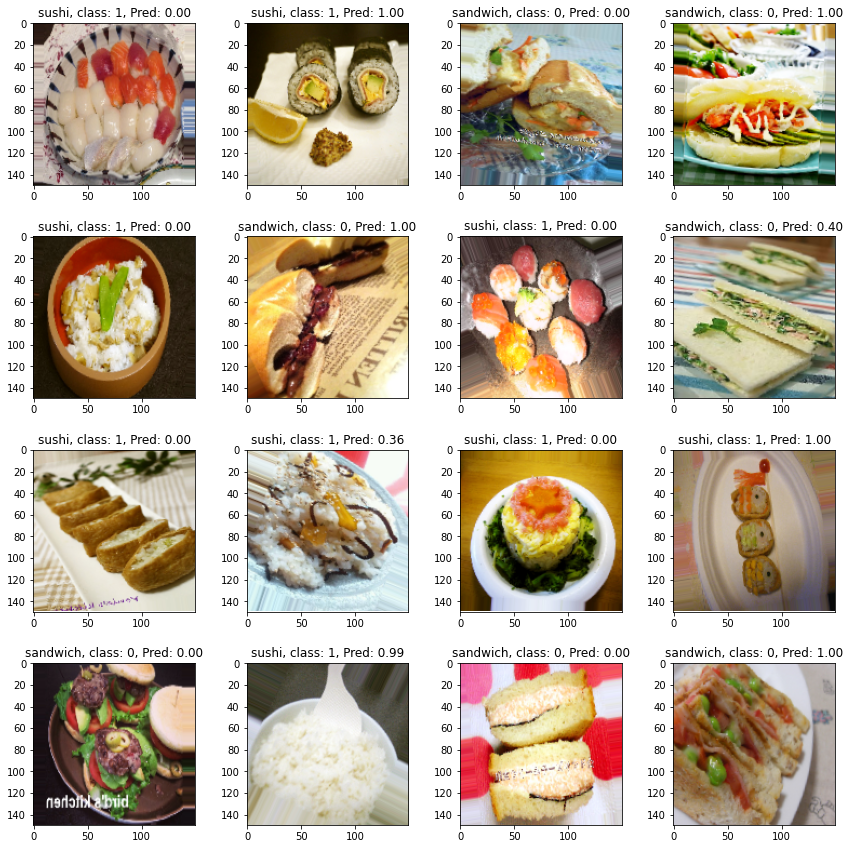

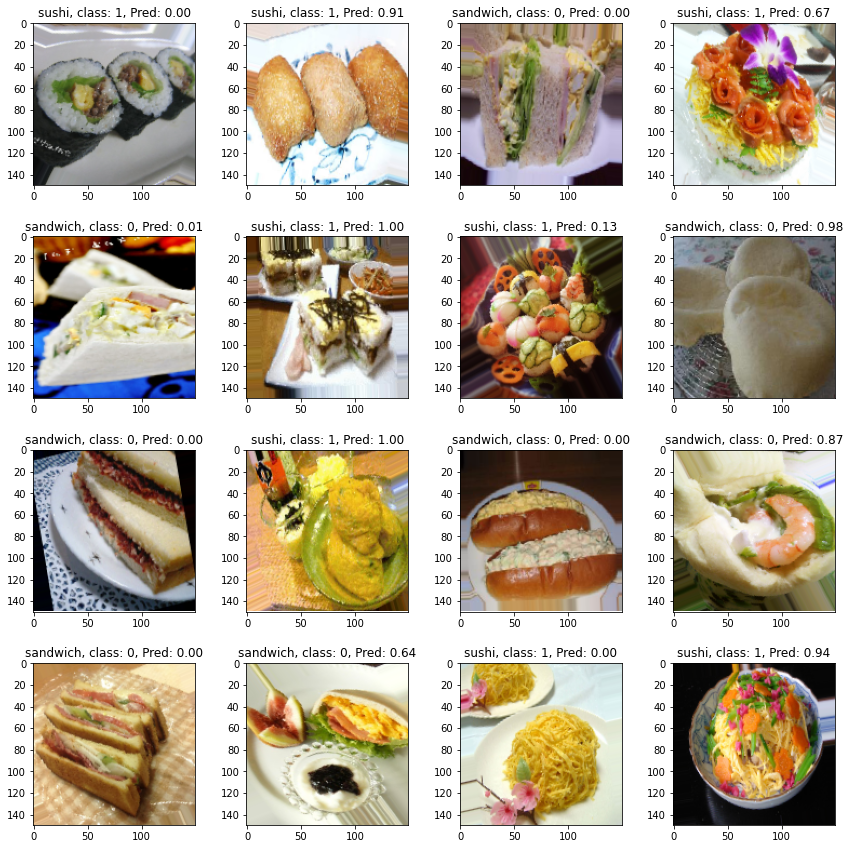

In [40]:
# Predict the correct class and categorize 
print(test_datagen.class_indices)
creatSushidiDir()
images, labels = test_datagen[0]
predictions = model_ModifiedNetV2.predict(images)

for ix,(im,l,p) in enumerate(zip(images,labels,predictions.flatten())):
    if ix%16 == 0:
        plt.figure(figsize=(12,12))
    plt.subplot(4,4,ix%16+1)
    plt.imshow(im)
    plt.imsave(sushidi_dir+"/sushidi"+ str(ix) + ".jpg", im)
    if l == 0:
      plt.title('sandwich, class: {:0.0f}, Pred: {:0.2f}'.format(l,p))
    elif l ==1:
       plt.title('sushi, class: {:0.0f}, Pred: {:0.2f}'.format(l,p))
    if (ix+1)%16 == 0:
        plt.tight_layout()

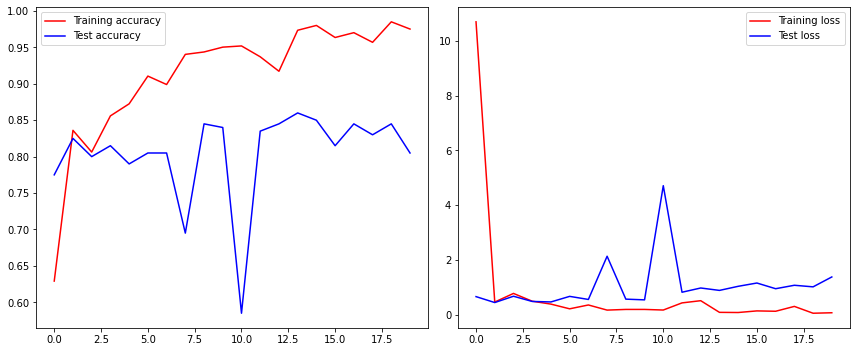

In [41]:
acc = history_MobileNetV2.history['accuracy']
val_acc = history_MobileNetV2.history['val_accuracy']
loss = history_MobileNetV2.history['loss']
val_loss = history_MobileNetV2.history['val_loss']

epochs = range(len(acc))

fit, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.axes_style('whitegrid')
# plot acrruacy by epochs
sns.lineplot(x=epochs, y=acc, color='r', label='Training accuracy', ax=axes[0])
sns.lineplot(x=epochs, y=val_acc, color = 'b', label='Test accuracy', ax=axes[0])
# plot loss by epochs
sns.lineplot(x=epochs, y=loss, color='r', label='Training loss', ax=axes[1])
sns.lineplot(x=epochs, y=val_loss, color = 'b', label='Test loss', ax=axes[1])
plt.tight_layout()
plt.show();